<a href="https://www.kaggle.com/code/avikumart/nlp-news-articles-classif-wordembeddings-rnn?scriptVersionId=103925474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

Text is one of the most widespread forms of sequence data. It can be understood as either a sequence of charactors or a sequence of words, but it's most common to work at level of words. Text-sequence processing includes following applications:

**Applications of deep learning for text data:**
1. Document classification
2. Articles lebelling
3. Sentiment analysis
4. Author identification
5. Question-answering
6. Language detection
7. Translation Tasks

- In true sense `deep learning models map the statistical structure of written language,` which is sufficient to solve many simple textual tasks and problems.
- Deep learning for natural-language processing is `pattern recognition applied to words, sequence, and paragraphs,` in much similar way that computer vision is pattern recognition applied to pixels.
- Deep-learning models don't take input as text like other models they only work with numeric tensors

**Three techniques to vectorize the text data:**
1. Segment text into words, and convert word into a vector
2. Segment text into charactors, and transform each chractors into a vector.
3. Extract n-grams of words, and transform each n-grams into a vector.

- There are many ways one can convert text to vector and it depends on what models one is using along with time or resources utilization.

**Typical workflow to prepare text data for machine learning models:**
1. Tokenization
2. One-Hot encoding or word indexing
3. Pad sequencing 
4. Embedding layer (Word2Vec)
5. Corresponding word vector

- In this notebook, we are going to explore and solve news classification problem to classify 41 types of news headlines and news descriptions.

**Use-case:** Such text classification models are used in `News Apps` or by reporter to classify news topics for better reach to right audience.

**Problem-statement:** Build `news classification model` using deep learning teechniques and deploy model for reporters to classify and label news articles.

*Reference: Deep learning with python by Francois Chollet*

TOC:

*this notebook is under progress*

*roadmap*

1 intro with text data workings, applications, problem-statement, use-case, steps and TOC
2 text data pre-processing, eda of dataset
3 tokenizatoin vectorization and word vectors explanation
5 model building using deep neural network
6 RNN and cnn1d Explanation and experimentation

# 0. Importing libraries

In [26]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
import pandas_profiling as pp
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional
from keras.models import Sequential

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings 
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. Data exploration and pre-processing

In [2]:
df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [3]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(200853, 6)
Unique categories: 41
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [4]:
# general descrption of dataset
df.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://stylelikeu.com/closets/megan-lecrone/,,2013-04-24 00:00:00
freq,32739,90,36620,2,19712,100
first,nan,nan,nan,nan,nan,2012-01-28 00:00:00
last,nan,nan,nan,nan,nan,2018-05-26 00:00:00


## 1.1 Profiling report of dataset

In [5]:
# produce pandas profiling report
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Key findings:**

1. Dataset has total **41** distinct categories of news articles
2. **'Politics'** is the most common category of news in our dataset.
3. We have total of **27993** unique authors who have written various news articles
4. Maximum length of headline is **320** while median length is around **59.**
5. Maximum length of description is **1472** while median length is around **120.**

## 1.2 Text data visualization

In [6]:
# drop columns like authors, links and date as they are irrelevent to our problem.
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."


### 1.2.1 TOP 10 Categories of News Articles

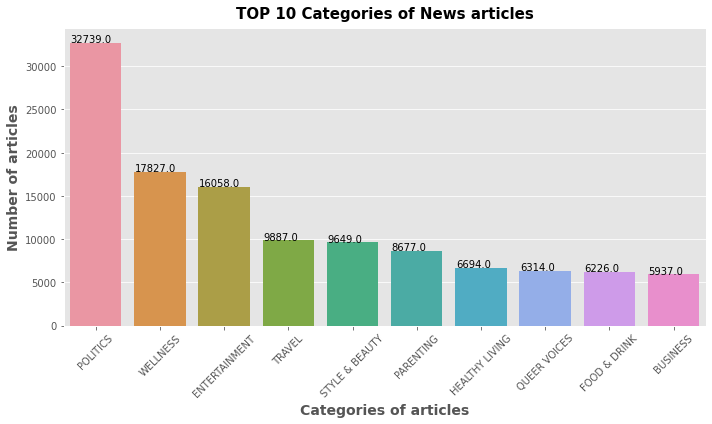

In [7]:
# Top categories by and number of articles per categories
cat_df = pd.DataFrame(new_df['category'].value_counts()).reset_index()
cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

# Visualize top 10 categories and proportion of each categories in dataset
plt.figure(figsize=(10,6))
ax = sns.barplot(np.array(cat_df.news_classes)[:10], np.array(cat_df.numcat)[:10])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
plt.title("TOP 10 Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()

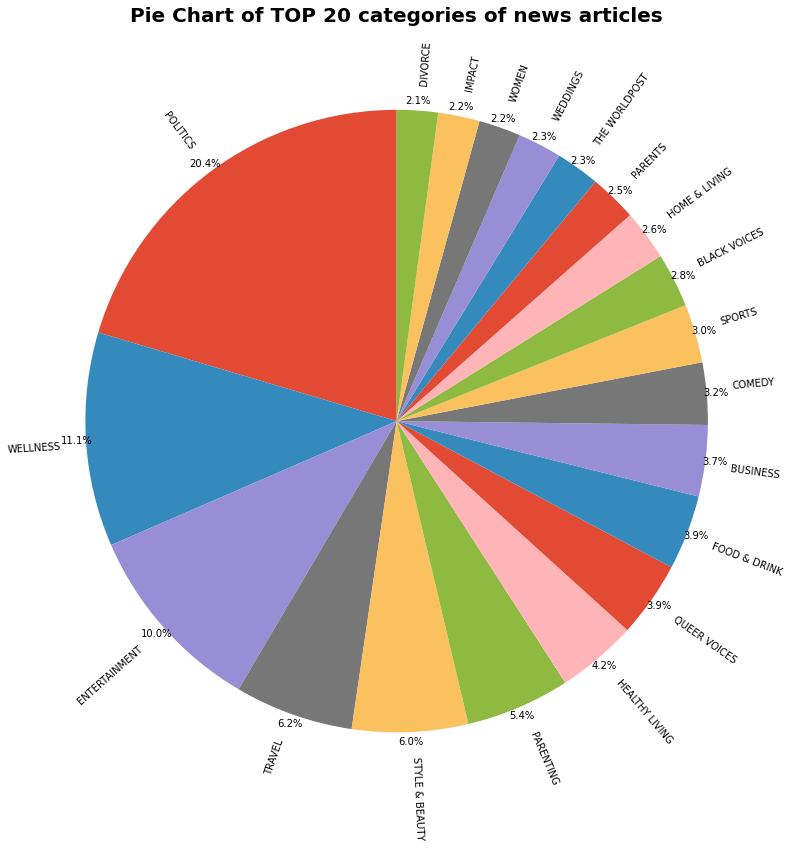

In [8]:
# plot the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:20],
            labels=cat_df['news_classes'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 20 categories of news articles", size=20, weight='bold')
plt.show()

### 1.2.2 Lengths of 'headline' and 'short_description' of each category

In [9]:
# create final dataframe of combined headline and short_description
final_df = new_df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

,category,length_of_news,len_news
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,140
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,99
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...,134
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,155
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,158


In [10]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

,category,len_news
24,POLITICS,1486
40,WORLDPOST,1424
4,COLLEGE,1225
16,HEALTHY LIVING,1073
37,WELLNESS,1036


In [11]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

,category,len_news
8,DIVORCE,66
33,THE WORLDPOST,56
35,WEDDINGS,54
21,MONEY,51
39,WORLD NEWS,51


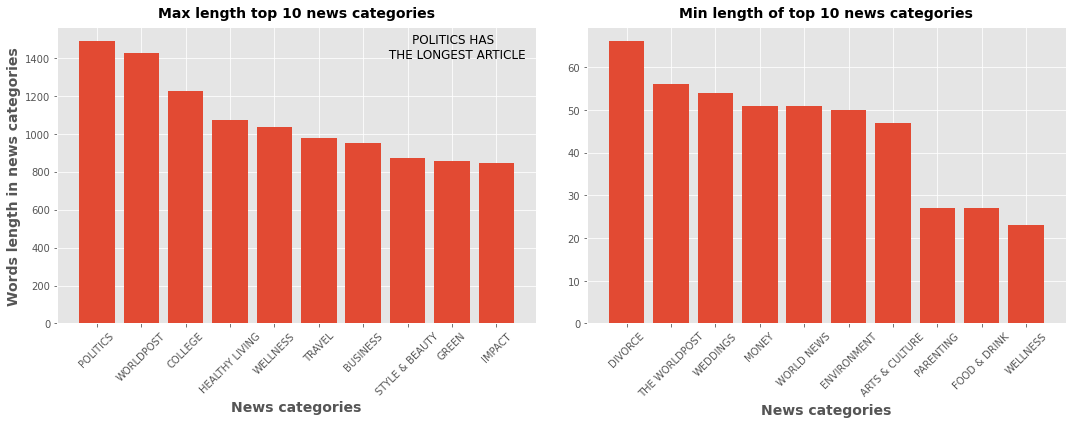

In [12]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:10],lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS 
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['category'][:10], lenmin_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

**Key findings:**

1. From all the categories of news **POLITICS** has the **most number of articles** as well as **length of characters** in the article (headlines and short-description)
2. After 'POLITICS' category, 'WORLDPOST', 'COLLEGE', 'HEALTHY LIVING','WELLNESS' categories are in top 5 most length of articles
3. 'POLITICS', 'WELLNESS' and 'ENTERTAINTMENT' are top 3 categories having most number of articles in out dataset.

### 1.2.3 Wordclouds of categories and news articles

- Wordcloud of categories in out dataframe
- Wordcloud of new articles in each of the categories

(-0.5, 1599.5, 599.5, -0.5)

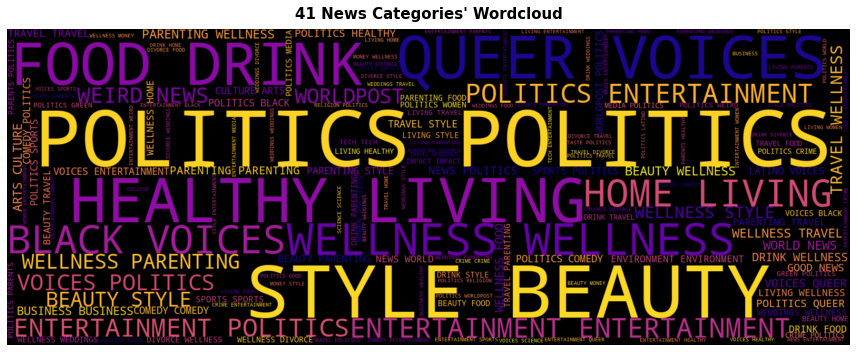

In [13]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(final_df.category))

plt.title("41 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

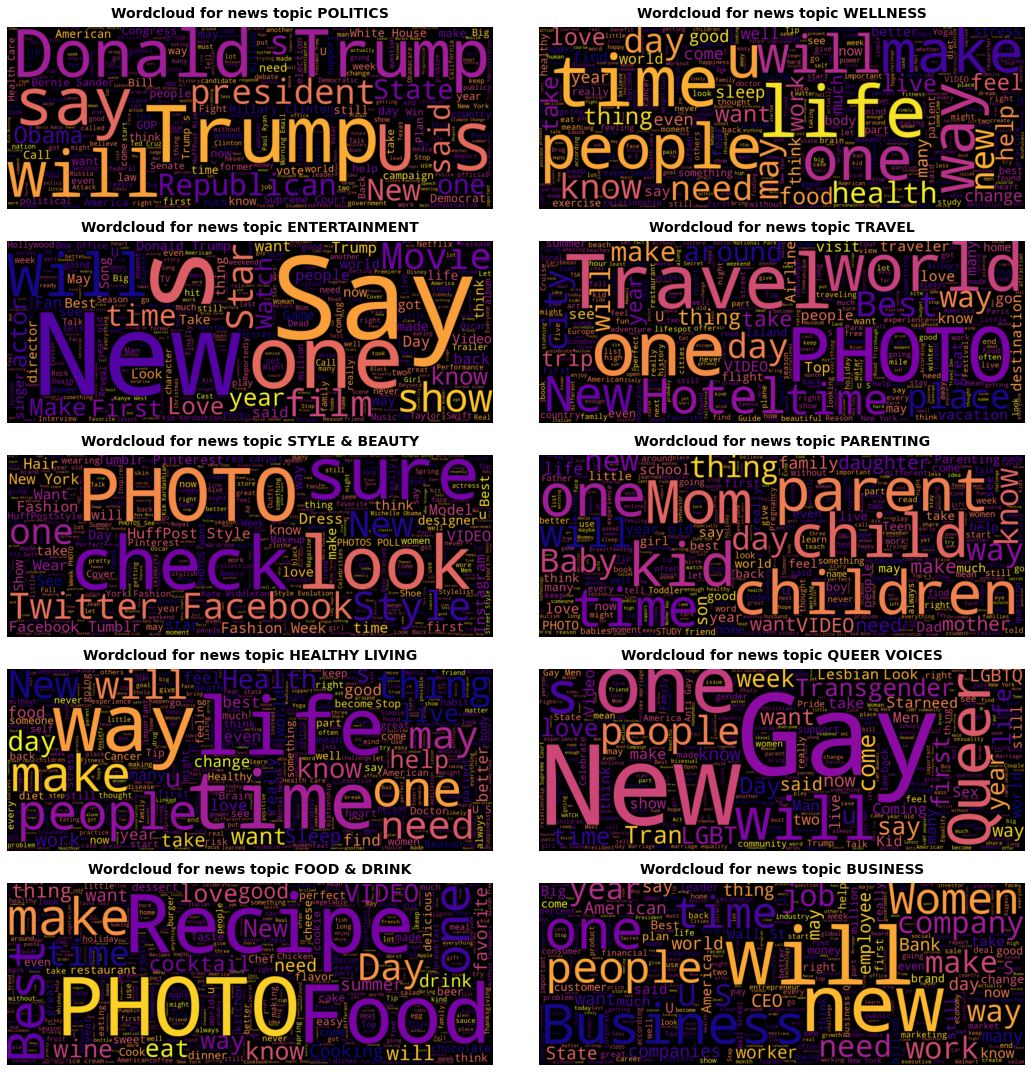

In [14]:
# create new dataframe of category and length of each news articles in that categories
ndf = final_df.copy()
ndf.drop('len_news', inplace=True, axis=1)

# list of top 10  categories in out dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)
    
# create a wordcloud instance
wc1 = WordCloud(max_words=1000, 
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

## 1.3 Text-data Preprocessing 

In [15]:
# start with removing some data from politics dataframe ndf
politics_list = list(ndf[ndf['category'] == 'POLITICS'].index) 
list_16 = politics_list[:16000] # list of 16000 row labels of POLITICS category

# drop these 16000 labels from the dataset
ndf2 = ndf.copy()
ndf2.drop(list_16, axis=0, inplace=True)

In [16]:
# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    
    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))
        
    return ' '.join(sentence)        

In [17]:
# Example of pre-processing using above function
print("Text sentence before pre-processing:\n",ndf2['length_of_news'][0])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(ndf2['length_of_news'][0]))

Text sentence before pre-processing:
 There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TVShe left her husband. He killed their children. Just another day in America.
---------------------------------------------------------------------------------------------------------
Text sentence after pre-processing:
 mass shoot texas last week tvshe leave husband kill children another day america


In [18]:
# apply datacleaning function to column 'length_of_news'
ndf2['length_of_news'] = ndf2['length_of_news'].apply(datacleaning)

In [19]:
# length of total characters before and after cleaning text data
old_length = ndf['length_of_news'].apply(len).sum()
new_length = ndf2['length_of_news'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 34597530
New chracters length of text data: 21978981


In [20]:
# length of total words before and after cleaning text data
old_text = ndf['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = ndf2['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 5697195
New word length of text data: 3140132


# 2. Tokenization and vectorization

### Some of the most common NLP terminologies

**1. Document**
- Each and every training example used in text dataset known as a Document.

**2. Corpus**
- Collections of documents called as a corpus of text data

**3. Vocabulary(BoW)**
- Vocabulary or Bag-of-words is nothing but number of unique words are present in text corpus.

**4. Stop words**
- Stop words are those used most commonly in any language, e.g. 'the', 'a', etc. they do not form any meaning to the context of the text

**5. N-grams**
- N-grams is text representation in form of N words sequences to extract meaning and context out of each sentences or paragraphs.

**6. Tokenization**
- It's an early step in NLP process to split text sentences into smaller words or tokens.

**7. Vectorization**
- Machine do not understand text or words, so text data or tokens must be converted to corrospinding word index or word vectors in order process text and build models. process of converting tokenized words into numerical vectors called as a vectorization.

### One-hot encoding and word-indexing example on chunk of data

In [21]:
# tokenization and vectorization workflow
# word level one-hot encoding for sample data

samples = list(ndf2['length_of_news'][:5].values)  # samples of first 5 documents of out dataset

token_index = {}  # builds an index of tokens in the data
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # assigning unique index to each unique words
            
max_length = 15

results = np.zeros(shape=(len(samples),   # results will be stored in this array
                          max_length,
                          max(token_index.values()) +1)) 

print("Shape of stored results array:", results.shape)
print("Token index of unique words: \n", token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape of stored results array: (5, 15, 72)
Token index of unique words: 
 {'mass': 1, 'shoot': 2, 'texas': 3, 'last': 4, 'week': 5, 'tvshe': 6, 'leave': 7, 'husband': 8, 'kill': 9, 'children': 10, 'another': 11, 'day': 12, 'america': 13, 'will': 14, 'smith': 15, 'join': 16, 'diplo': 17, 'nicky': 18, 'jam': 19, 'world': 20, 'cup': 21, 'official': 22, 'songof': 23, 'course': 24, 'song': 25, 'hugh': 26, 'grant': 27, 'marry': 28, 'first': 29, 'time': 30, 'age': 31, 'actor': 32, 'longtime': 33, 'girlfriend': 34, 'anna': 35, 'eberstein': 36, 'tie': 37, 'knot': 38, 'civil': 39, 'ceremony': 40, 'jim': 41, 'carrey': 42, 'blast': 43, 'castrato': 44, 'adam': 45, 'schiff': 46, 'democrats': 47, 'new': 48, 'artworkthe': 49, 'give': 50, 'dems': 51, 'asskicking': 52, 'fight': 53, 'hard': 54, 'enough': 55, 'donald': 56, 'trump': 57, 'julianna': 58, 'margulies': 59, 'use': 60, 'poop': 61, 'bag': 62, 'pick': 63, 'dogthe': 64, 'dietland': 65, 'actress': 66, 'say': 67, 'really': 68, 'cathartic': 69, 'thera

### One-hot encoding and indexing of train and test data

In [31]:
# one hot encoding using keras tokenizer and pad sequencing
X = ndf2['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(ndf2['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>') 
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor 

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 100 # max length of sequence 
y_train = to_categorical(y_train, num_classes=41)
y_test = to_categorical(y_test, num_classes=41)
print("Length of word index:", total_words)

shape of input data:  (184853,)
shape of target variable:  (184853,)
Length of word index: 174809


# 3. What are the Wordembeddings?

> A word embedding is a learned representation for text where words that have the same meaning and save similar representation

Reference:- [Machinelearningmastery](https://machinelearningmastery.com/what-are-word-embeddings/)

- This approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on chllengin NLP problems
- Word embeddings are alternative to one-hot encoding along with dimensionality reduction

> One-hot word vectors - Sparse, High-dimensional and Hard-coded 

> Word embeddings - Dense, Lower-Dimensional and Learned from the data

- Keras library has embeddings layer which does word representation of given text corpus 

**tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs
)**

**Key Arguments:**

1) input_dim - Size of vocabulary - length of word index

2) output_dim - Output dimention of word representation

3) input-length - max input sequence length of document

**Visual depiction of word embeddings:-**

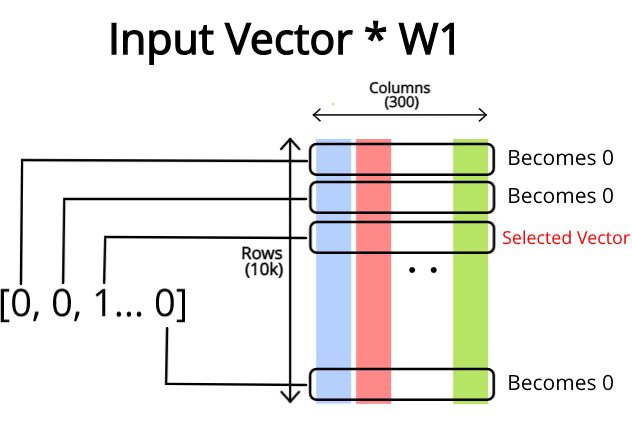

# 4. Model training using embedding layer and RNN (Baseline)

In [36]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(41, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 70)           12236630  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          17280     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 128)          24704     
_________________________________________________________________
simple_rnn_20 (SimpleRNN)    (None, 32)                5152      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 41)                1353      
Total params: 12,285,119
Trainable params: 12,285,119
Non-trainable params: 0
__________________________________________

## 4.1 What are the Recurrent Neural Networks??

- A major difference between densely connected neural network and recurrent nueral network, is that fully connected networks have no memory in units of each layer. while `recurrent nueral networks do store state of previous timestep or sequence` while assigning weights  to current input.

- In RNNs, we `process inputs word by word or eye saccade but eye saccade` - while keeping memories of what came before in each cells. this gives fluid representation of sequences and gives nueral network a ability to capture context of sequence rather than absolute representation of words.

> "Recurrent nueral network processes sequences by iterating through the sequence elements and maintaining a a `state` containing information relative to what it has seen so far. In effect, an RNN is a type of nueral network that has an internal loop."

-6.2 Understanding recurrent nueral network, Deep learning using python by chollat

- See the below depiction of how RNNs learns the context of sequences.

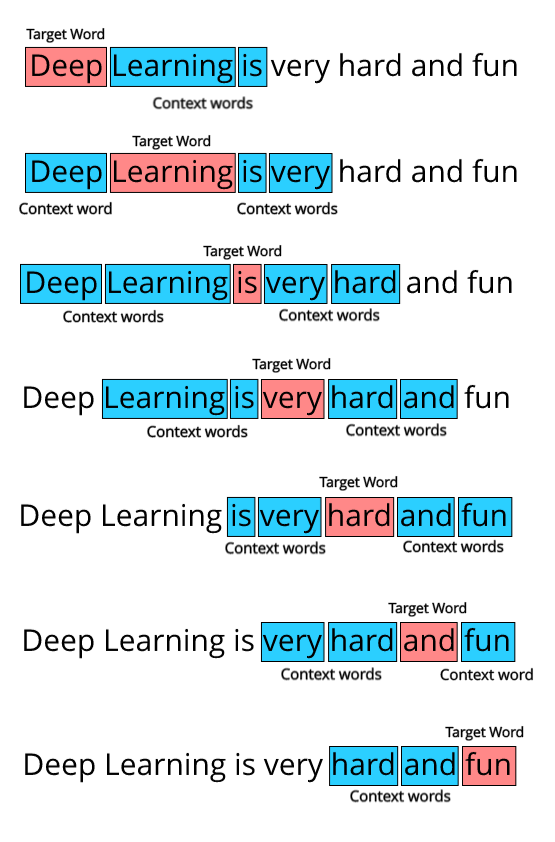

- A visual dipiction of RNN cell with a loop and unrolled RNN cell.

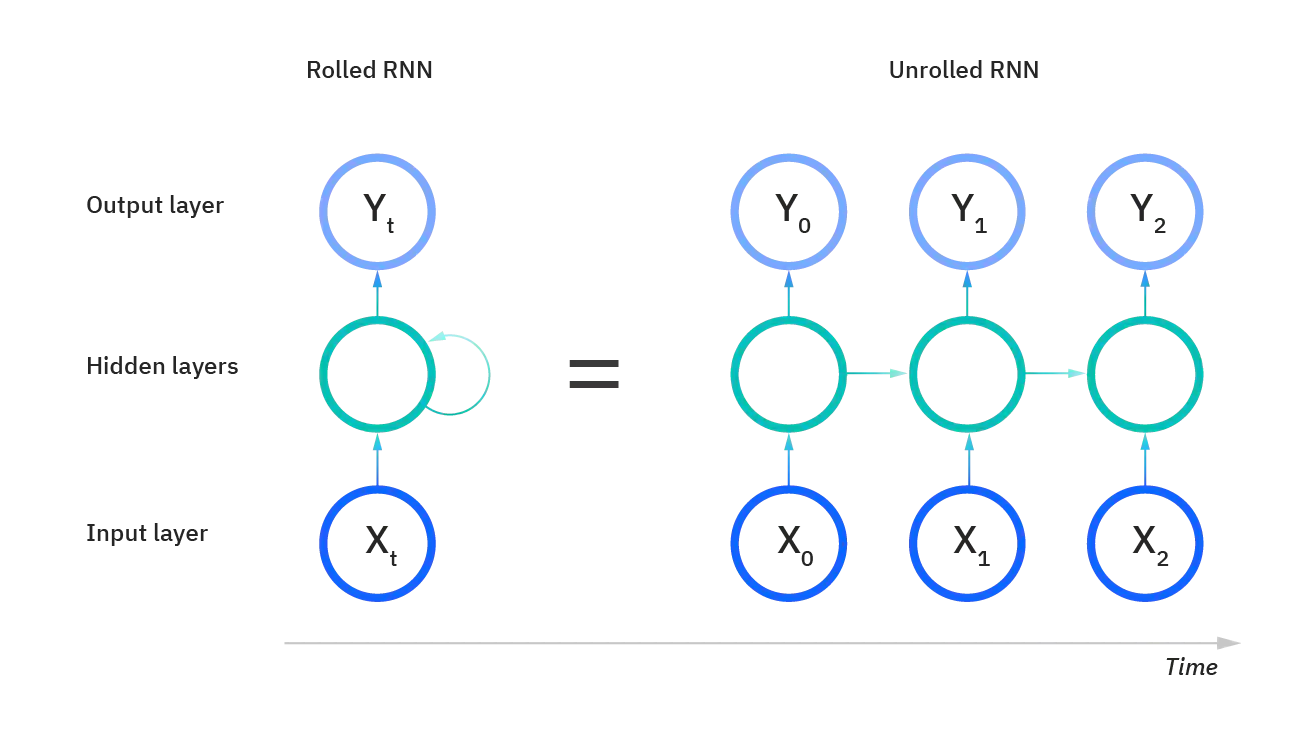

In [37]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train, 
                    batch_size=128, 
                    epochs=15, 
                    validation_split=0.2
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
925/925 [==============================] - 132s 139ms/step - loss: 3.1441 - accuracy: 0.1890 - val_loss: 2.7926 - val_accuracy: 0.2803
Epoch 2/15
925/925 [==============================] - 127s 137ms/step - loss: 2.6414 - accuracy: 0.3134 - val_loss: 2.5427 - val_accuracy: 0.3461
Epoch 3/15
925/925 [==============================] - 127s 137ms/step - loss: 2.3280 - accuracy: 0.3961 - val_loss: 2.3045 - val_accuracy: 0.4075
Epoch 4/15
925/925 [==============================] - 126s 136ms/step - loss: 2.1128 - accuracy: 0.4528 - val_loss: 2.2050 - val_accuracy: 0.4323
Epoch 5/15
925/925 [==============================] - 129s 140ms/step - loss: 1.9673 - accuracy: 0.4900 - val_loss: 2.1326 - val_accuracy: 0.4556
Epoch 6/15
925/925 [==============================] - 126s 136ms/step - loss: 1.8647 - accuracy: 0.5133 - val_loss: 2.1331 - val_accuracy: 0.4627
Epoch 7/15
925/925 [==============================] - 128s 139ms/step - loss: 1.7776 - accuracy: 0.5367 - val_loss: 2.1388 -

**Notes:**

- Experiment 1: 
Parameters: max_words=100000, output_dim=50, maxlen=50, epoch=10.
Model is highly overfitting as training accuracy comes around 84% while test accuracy is barely 40%.

- Experiment 2:
Params: max_words=150000, out_dim=50, maxlen=80, epoch=10, added droput layers in RNN
Model do not overfit but underfit and biased. val_acc comes again almost 39.3% while train accuracy is only 42%. model needs more parameters with more epochs

- Experiment 3:
Params: max_words=total_words, out_dim=70, maxlen=100, epoch=15, addding bidirection layer over both dropout RNN
an improvement in train accuracy to 63% and val_accuracy to 49% max at epoch 13. after epoch 13 model started overfitting. (next step) model can be more complex with regularization, model is forgetting information after 3rd RNN layer due to lower number of units, this needs to be solved.

In [38]:
model.save("news_clf_exp03.h5")